# Rolling Planning mit Lateness (Tardiness + Earliness)

In [1]:
import sys
import os

# Projektverzeichnis
project_root = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))

# Füge dem sys.path hinzu, falls noch nicht vorhanden
if project_root not in sys.path:
    sys.path.append(project_root)

In [13]:
# Datenzugriff
from configs.config import get_path

# Utils
import src.utils.presenter as show
from src.utils.production_process import convert
from src.utils.production_process import initialize as init
from src.utils.analize import check_constrains as check

from src.utils.production_process import time_determination as term
from src.utils.production_process import gen_deadline as gen_deadline
from src.utils.production_process import filter as process_filter

# Solver Model
from src.models.cp import lateness_scheduling as cp_late_schedule
from src.models.cp import lateness_rescheduling as cp_late_reschedule
import src.models.heuristics.fcfs as fcfs


# Simulation
from src.simulation.ProductionSimulation import ProductionSimulation

# Extern
import pandas as pd
import numpy as np
pd.set_option('display.max_rows', 21)

In [14]:
max_time = 60 * 15 # 15 min

In [15]:
data_path = get_path("data", "cp_lateness")
file_template = "02_{text}.csv"

## Laden des fertigen Datensatzes (über 100 Tage Ankunft)

In [16]:
day_count = 600
basic_data_path = get_path("data", "basic")
df_job_times = pd.read_csv(basic_data_path / f"jobs_times_{day_count}_final.csv")
df_job_times

,Job,Production_Plan_ID,Arrival,Ready Time,End,Processing Time,Deadline
0,0,0,51,1440,3050.0,395,3302
1,1,1,136,1440,2736.0,510,2401
2,2,2,158,1440,2258.0,568,2557
3,3,3,236,1440,2926.0,655,1873
4,4,4,404,1440,3007.0,393,3093
...,...,...,...,...,...,...,...
12371,12371,1,863835,864000,865696.0,510,901715
12372,12372,7,863862,864000,865958.0,539,1023279
12373,12373,4,863874,864000,866053.0,393,1072096
12374,12374,2,863878,864000,866078.0,568,898007


In [17]:
df_jssp = pd.read_csv(basic_data_path / f"jssp_{day_count}.csv")
df_jssp

,Job,Production_Plan_ID,Operation,Machine,Processing Time,Arrival,Ready Time
0,0,0,0,M00,29,51,1440
1,0,0,1,M01,78,51,1440
2,0,0,2,M02,9,51,1440
3,0,0,3,M03,36,51,1440
4,0,0,4,M04,49,51,1440
...,...,...,...,...,...,...,...
123755,12375,5,5,M09,72,863991,864000
123756,12375,5,6,M00,47,863991,864000
123757,12375,5,7,M06,65,863991,864000
123758,12375,5,8,M04,6,863991,864000


### Params

In [18]:
day_length = 1440
day_numb = 0
day_start = day_length*day_numb 
day_end = day_start + day_length
print(f"Tag {day_numb:02d}: [{day_start}, {day_end})")

Tag 00: [0, 1440)


> Tag 0 wird nicht ausgeführt

## Tag 1 (init. Tag - kein Rescheduling)

In [19]:
day_numb = 1

day_start = day_length*day_numb 
day_end = day_start + day_length
print(f"Tag {day_numb:02d}: [{day_start}, {day_end})")

Tag 01: [1440, 2880)


In [20]:
# aktuelle Produktionaufträge
df_jssp_curr, df_job_times_curr = process_filter.jobs_by_ready_time(df_job_times, df_jssp, ready_time = day_start)
df_job_times_curr

,Job,Production_Plan_ID,Arrival,Ready Time,End,Processing Time,Deadline
0,0,0,51,1440,3050.0,395,3302
1,1,1,136,1440,2736.0,510,2401
2,2,2,158,1440,2258.0,568,2557
3,3,3,236,1440,2926.0,655,1873
4,4,4,404,1440,3007.0,393,3093
5,5,5,485,1440,2731.0,496,2665
6,6,6,501,1440,2646.0,416,2430
7,7,7,528,1440,3085.0,539,4218
8,8,8,550,1440,2985.0,597,3151
9,9,9,559,1440,2970.0,540,2615


### A) Scheduling

In [21]:
# Scheduling
df_schedule = cp_late_schedule.solve_jssp_sum_by_tardiness_and_earliness(df_jssp_curr, df_job_times_curr, 
                                                                         schedule_start = day_start, w_t=5,
                                                                         msg=False, timeLimit=max_time)
df_schedule 


Solver-Status         : OPTIMAL
Objective Value       : 1110.00
Best Objective Bound  : 1110.00
Laufzeit              : 0.16 Sekunden


,Job,Production_Plan_ID,Operation,Machine,Arrival,Deadline,Start,Processing Time,End,Lateness,Tardiness,Earliness
0,1,1,0,M00,136,2401,1440,43,1483,-918,0,918
1,3,3,0,M01,236,1873,1440,81,1521,-352,0,352
2,15,7,0,M02,1193,3082,1440,31,1471,-1611,0,1611
3,4,4,0,M02,404,3093,1471,14,1485,-1608,0,1608
4,12,8,0,M00,992,2717,1483,76,1559,-1158,0,1158
...,...,...,...,...,...,...,...,...,...,...,...,...
175,17,3,8,M09,1343,3576,3374,22,3396,-180,0,180
176,16,1,9,M08,1310,3414,3384,30,3414,0,0,0
177,17,3,9,M05,1343,3576,3533,43,3576,0,0,0
178,14,4,9,M06,1177,4133,4080,53,4133,0,0,0


In [22]:
last_ops = df_schedule.sort_values(['Job', 'Operation']).drop_duplicates('Job', keep='last')
print(show.count_column_grouped(last_ops, 'Lateness'))

label
<-180           0
-180 - -120     0
-120 - -60      0
-60 - 0         0
0              17
0 - 60          0
60 - 120        0
120 - 180       0
>180            1
Name: count, dtype: int64


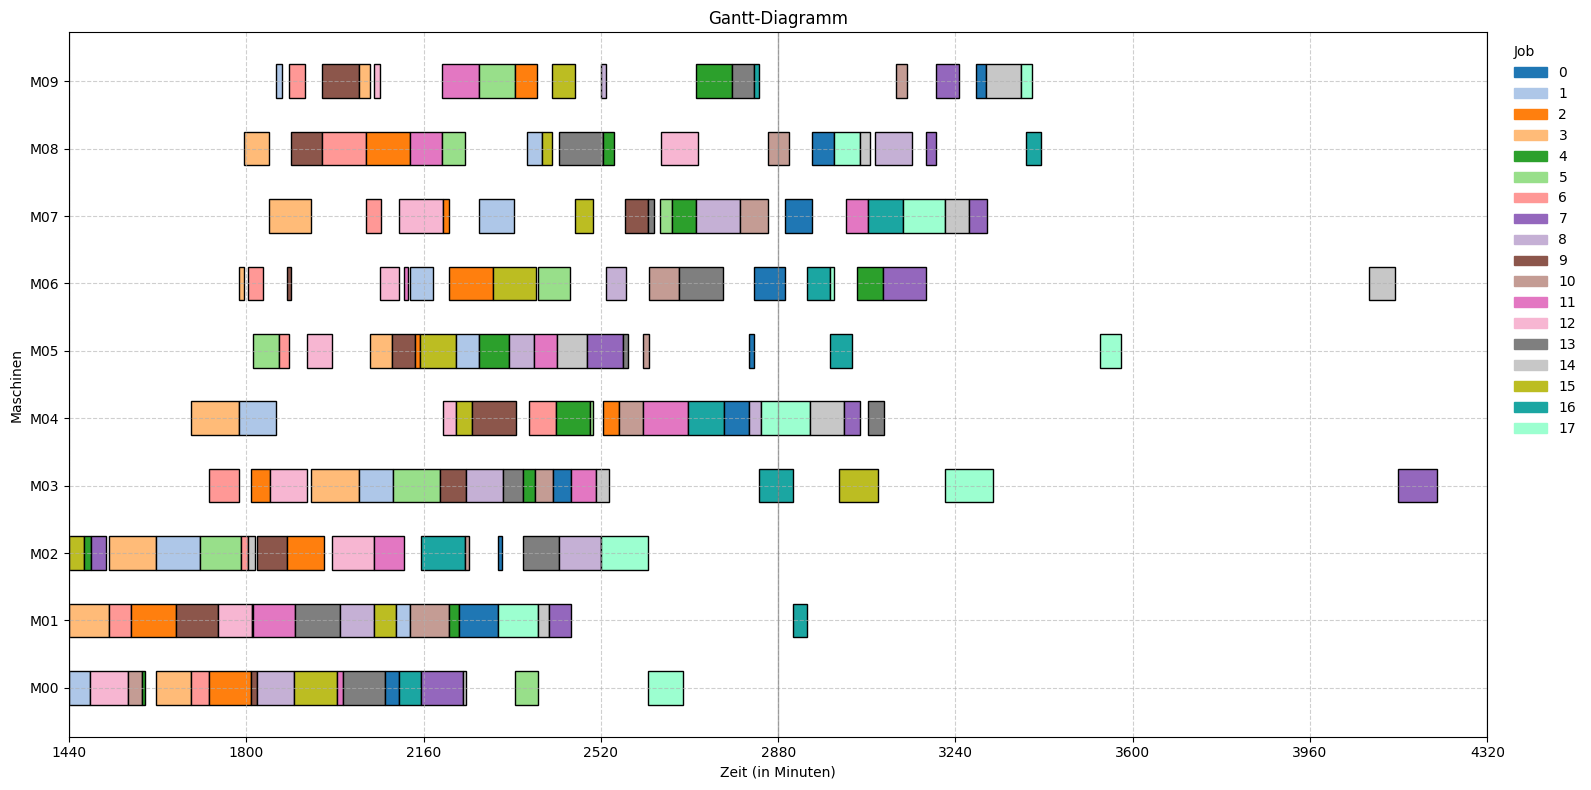

+ Keine Maschinenkonflikte gefunden
+ Alle Gruppen wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten wurden eingehalten.
+ Alle Operation starten erst nach Arrival des Job


True

In [23]:
show.plot_gantt(df_schedule, perspective="Machine")
check.is_machine_conflict_free(df_schedule)
check.is_operation_sequence_correct(df_schedule)
check.is_job_timing_correct(df_schedule)
check.is_start_correct(df_schedule)

In [24]:
file = file_template.format(text= f"schedule_{day_numb:02d}_init")
file

'02_schedule_01_init.csv'

In [25]:
df_schedule.to_csv(data_path / file, index = False)

### C) Simulation

In [26]:
simulation = ProductionSimulation(df_schedule, sigma=0.25)
df_execution = simulation.run(start_time = day_start, end_time=day_end)

[Day 1 00:00:00] Job 1 started on M00
[Day 1 00:00:00] Job 3 started on M01
[Day 1 00:00:00] Job 15 started on M02
[Day 1 00:31:23] Job 15 finished on M02 (after 31 minutes 23 seconds)
[Day 1 00:31:23] Job 4 started on M02
[Day 1 00:45:32] Job 1 finished on M00 (after 45 minutes 33 seconds)
[Day 1 00:45:32] Job 12 started on M00
[Day 1 00:48:52] Job 4 finished on M02 (after 17 minutes 29 seconds)
[Day 1 00:48:52] Job 7 started on M02
[Day 1 01:25:54] Job 7 finished on M02 (after 37 minutes 01 second)
[Day 1 02:06:49] Job 12 finished on M00 (after 81 minutes 17 seconds)
[Day 1 02:06:49] Job 10 started on M00
[Day 1 02:19:07] Job 3 finished on M01 (after 139 minutes 08 seconds)
[Day 1 02:19:07] Job 6 started on M01
[Day 1 02:19:07] Job 3 started on M02
[Day 1 02:43:40] Job 10 finished on M00 (after 36 minutes 51 seconds)
[Day 1 02:43:40] Job 4 started on M00
[Day 1 02:48:49] Job 4 finished on M00 (after 05 minutes 09 seconds)
[Day 1 03:05:02] Job 6 finished on M01 (after 45 minutes 55 se

In [27]:
df_plan_undone = process_filter.get_unexecuted_operations(df_schedule, df_execution)
df_plan_undone 

,Job,Production_Plan_ID,Operation,Machine,Arrival,Deadline,Start,Processing Time,End,Lateness,Tardiness,Earliness
0,0,0,5,M05,51,3302,2820,11,2831,-471,0,471
1,8,8,8,M04,550,3151,2820,26,2846,-305,0,305
2,0,0,6,M06,51,3302,2831,62,2893,-409,0,409
3,16,1,3,M09,1310,3414,2831,11,2842,-572,0,572
4,16,1,4,M03,1310,3414,2842,69,2911,-503,0,503
...,...,...,...,...,...,...,...,...,...,...,...,...
33,17,3,8,M09,1343,3576,3374,22,3396,-180,0,180
34,16,1,9,M08,1310,3414,3384,30,3414,0,0,0
35,17,3,9,M05,1343,3576,3533,43,3576,0,0,0
36,14,4,9,M06,1177,4133,4080,53,4133,0,0,0


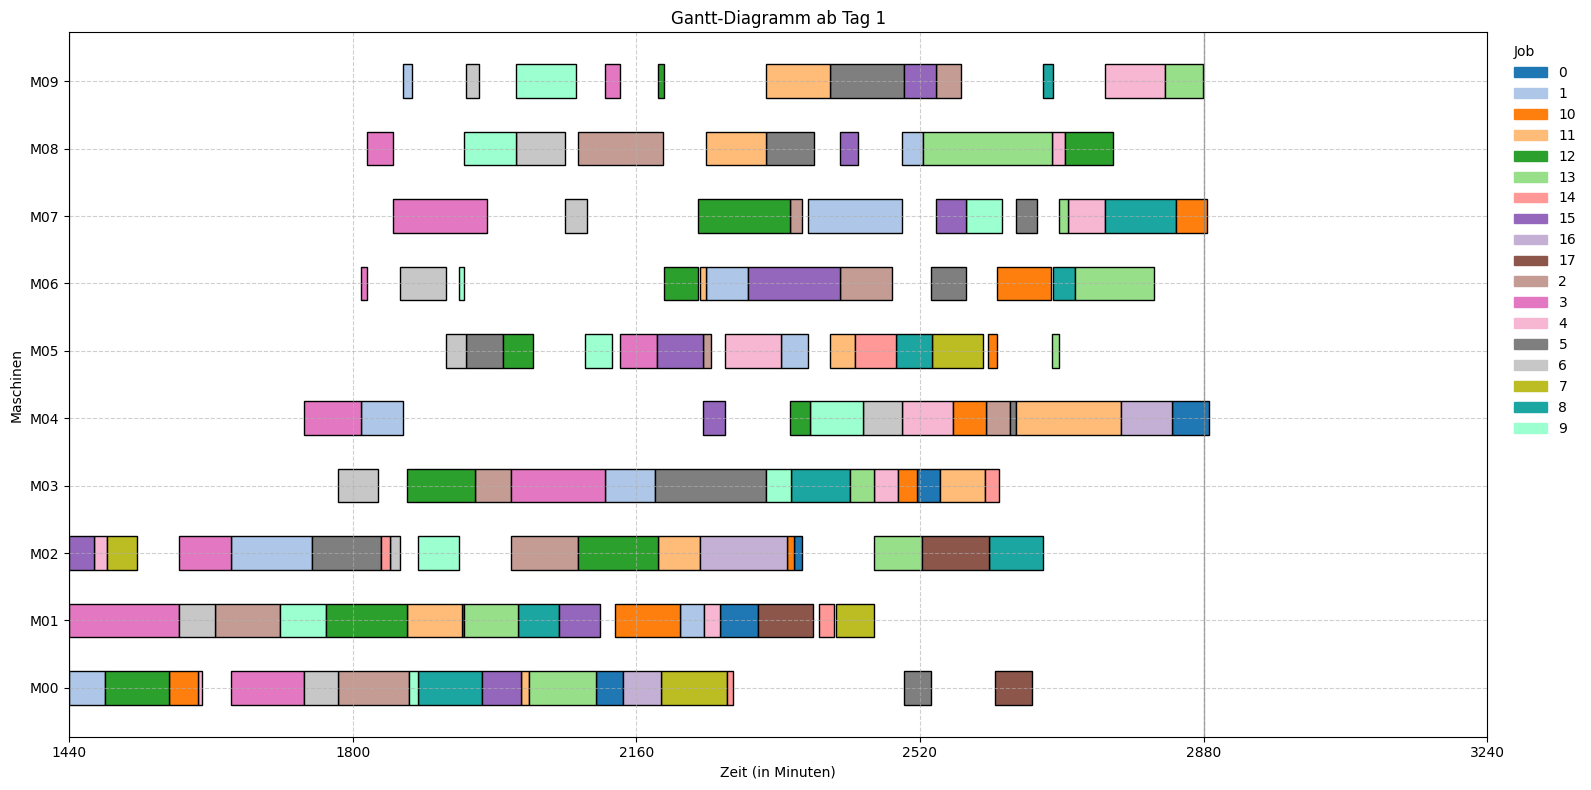

In [28]:
if not df_execution.empty:
    show.plot_gantt(df_execution, perspective="Machine", title=f"Gantt-Diagramm ab Tag {day_numb}")
else:
    print(f"Nothing executed on day {day_numb}")

In [29]:
undone_numb = len(df_plan_undone)
print(f"Number of undone operations: {undone_numb}")

Number of undone operations: 38


In [30]:
file = file_template.format(text= f"execution_{day_numb:02d}")
file

'02_execution_01.csv'

In [31]:
df_execution.to_csv(data_path / file, index = False)

In [32]:
file = file_template.format(text= f"plan_{day_numb:02d}_undone")
file

'02_plan_01_undone.csv'

In [33]:
df_plan_undone.to_csv(data_path / file, index = False)